In [1]:
%run ./modules.ipynb

/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `Group` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `AutoGroup` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `ImportGroup` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member
/srv/conda/envs/notebook/lib/python3.7/site-packages/aiida/orm/groups.py:61: UserWarning: no registered entry point for `UpfFamily` so its instances will not be storable.
  warnings.warn(message)  # pylint: disable=no-member


Paths to input .xyz files and output .npz file containing all the calculated geometric descriptors

In [6]:
path_to_input='../example_data/example_data_MP.xyz'
path_to_output='../example_data/geometric_example_MP.npz'

In [3]:
sns.set(style="white", palette="muted", color_codes=True)
my_c=colors.ListedColormap(["mediumblue", 'red'])
c= ["mediumblue", 'red']
sns.set_palette(sns.color_palette(c))

In [4]:
my_frames=ase.io.read(path_to_input, index=':')
len(my_frames)

840

How GLOBAL DESCRIPTORS for the packing analysis are created. You can skip this step and directly use the example_data/geometric_example_MP.npz file, jumping to the PLOTTING section. 

In [5]:
fcc=np.zeros(len(my_frames))
fcc_red=np.zeros(len(my_frames))
packing=np.zeros(len(my_frames))
n_species=np.zeros(len(my_frames))
cn=np.zeros(len(my_frames))
alpha=np.zeros(len(my_frames))
x=np.zeros(len(my_frames))
std_ratio=np.zeros(len(my_frames))
magic=np.zeros(len(my_frames))
natoms=np.zeros(len(my_frames))
hcp=np.zeros(len(my_frames))
hcp_red=np.zeros(len(my_frames))
red_frame=[]

In [6]:
for i, k in zip(my_frames, range(len(my_frames))):
    i.wrap(eps=1e-10)
    natoms[k]=len(i)
    if len(i)%4==0:
        magic[k]=1
    frame_py=get_pymatgen(i)
    v=i.get_volume()  #unit = A^^3
    el=i.get_chemical_symbols()
    n_species[k]=(len(np.unique(el)))
    rad=get_r(el)
    indexes = [i for i,x in enumerate(rad) if x == max(i for i in rad if i is not None)]
    max_el=np.array(i.get_chemical_symbols())[indexes]
    max_pos=np.array(i.get_positions())[indexes]
    new=Atoms(max_el, positions=max_pos, pbc=True, cell=i.get_cell())
    red_frame.append(new)
    sg_red=(ase.spacegroup.get_spacegroup(new, symprec=1e-05))
    sg=ase.spacegroup.get_spacegroup(i, symprec=1e-05)
    if 220<sg.no<231:
        fcc[k]=int(1)
    if 190<sg.no<195:
        hcp[k]=int(1)
    if 220<sg_red.no<231:
        fcc_red[k]=int(1)
    if 190<sg_red.no<195:
        hcp_red[k]=int(1)
    v_atom=sum([(4/3)*pi*(rad[i]/100)**3 for i in range(len(rad))])
    nn=np.zeros(len(el))
    for l in range(len(el)):   
        try:
            nn[l]=CrystalNN(weighted_cn=False, distance_cutoffs=None, x_diff_weight=0.0,
                    porous_adjustment=False).get_cn(frame_py, l)
        except:
            pass
    cn[k]=nn.mean()
    rad=np.array(rad)
    n_s=np.count_nonzero(rad == np.min(rad))
    n_l=np.count_nonzero(rad == np.max(rad))
    alpha[k]=np.min(rad)/np.max(rad)
    x[k]=n_s/(n_s+n_l)
    std_ratio[k]=np.std(rad)
    packing[k]=v_atom/v

In [8]:
dict={r'$\alpha$':alpha,r'$x$':x, r'$\sigma_{radii}$':std_ratio,
    r'$CN_{avg}$':cn, r'$N_{atoms,cell}$': natoms.ravel(), r'$PF$':packing,
'magic':magic.ravel(), r'$N_{species}$': n_species, 'FCC$_{tot}$':fcc,'FCC$_{red}$':fcc_red, 'HCP$_{tot}$':hcp, 'HCP$_{red}$':hcp_red}
df= pd.DataFrame(dict)

In [6]:
file=np.savez(path_to_output, magic=magic,cn=cn, n_species=n_species, 
              natoms=natoms, fcc=fcc,hcp=hcp, packing=packing, alpha=alpha, x=x, 
              std_ratio=std_ratio)

ARE MAGIC STRUCTURES MOSTLY FCC OR HCP ?

In [9]:
print('total structure: between HCP, '+str(len(df.loc[((df['magic']==1) & (df[r'HCP$_{tot}$']==1))])/len(df.loc[((df[r'HCP$_{tot}$']==1))]))+' percent are magic, reduced structure: between HCP, '+str(len(df.loc[((df['magic']==1) & (df[r'HCP$_{red}$']==1))])/len(df.loc[((df[r'HCP$_{red}$']==1))]))+' percent are magic', 
'total structure: between FCC, '+str(len(df.loc[((df['magic']==1) & (df[r'FCC$_{tot}$']==1))])/len(df.loc[((df[r'FCC$_{tot}$']==1))]))+' percent are magic, reduced structure: between FCC, '+str(len(df.loc[((df['magic']==1) & (df[r'FCC$_{red}$']==1))])/len(df.loc[((df[r'FCC$_{red}$']==1))]))+' percent are magic')

total structure: between HCP, 0.35714285714285715 percent are magic, reduced structure: between HCP, 0.4827586206896552 percent are magic total structure: between FCC, 0.3404255319148936 percent are magic, reduced structure: between FCC, 0.44285714285714284 percent are magic


PLOTTING

In [28]:
npzfile = np.load(path_to_output, allow_pickle=True)

Printing out all values stored in the .npz file:

In [30]:
for k in npzfile.files:
    print(k)
n_species=npzfile['n_species']
dict={r'$\alpha$':npzfile['alpha'],r'$x$':npzfile['x'], r'$\sigma_{radii}$':npzfile['std_ratio'],
     r'$N_{atoms,cell}$': npzfile['natoms'].ravel(), r'$PF$':npzfile['packing'],
'magic':npzfile['magic'].ravel(), r'$N_{species}$': npzfile['n_species']}
df= pd.DataFrame(dict)

magic
cn
n_species
natoms
fcc
hcp
packing
alpha
x
std_ratio


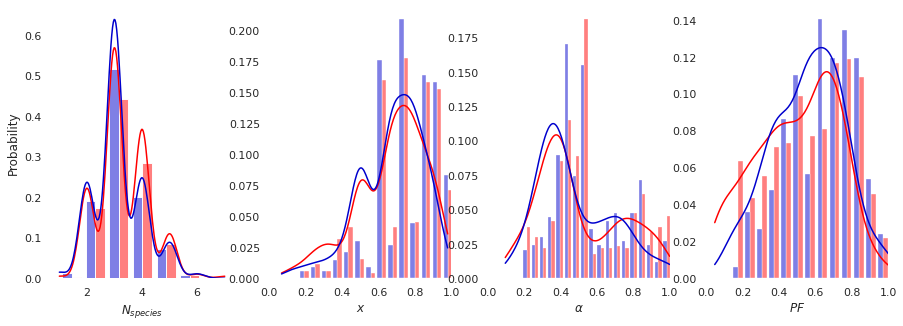

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

sns.histplot(ax=ax1, data=df, x=r'$N_{species}$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=int(max(n_species)), kde=True)

sns.histplot(ax=ax2, data=df, x=r'$x$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, kde=True)
ax2.set_ylabel(None)
ax2.set_xlim(0,1)

sns.histplot(ax=ax3, data=df, x=r'$\alpha$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, bins=20, kde=True)
ax3.set_xlim(0,1)
ax3.set_ylabel(None)

sns.histplot(ax=ax4, data=df, x=r'$PF$', hue='magic',stat='probability', legend=False,
               common_norm=False,  multiple='dodge', shrink=.8, kde=True)
ax4.set_ylabel(None)
ax4.set_xlim(0,1)

sns.despine(left=True, bottom=True)

POINT GROUPS AND SPACE GROUPS - LOCAL SYMMETRIES 

In [9]:
sg_list=[]
pg_list=[]
for j in range(len(my_frames)):
    frame=my_frames[j]
    sg=ase.spacegroup.get_spacegroup(frame, symprec=1e-05)
    sg=sg.no
    sg_list.append(sg)
    sp_group=point_group(sg)
    pg_list.append(pg)

In [18]:
"""This code doesn't return errors only works if the number of frames is larger and there is at least one example 
per point group"""

dict={'point_group':pg_list, 'magic':magic.ravel()} 
df= pd.DataFrame(dict)
m=df.loc[df['magic'] == 1]
nm=df.loc[df['magic'] == 0]

pg_list_order=['1', '1_','2','m','2/m', 
               'mm2','222',  'mmm',
               '4', '4_',  '4_2m','4mm', '422', '4/m','4/mmm',
               '3', '3m', '3_','32', '3_m','6', '6_',
                '6_m2',  '6/m','622','6mm',  '6/mmm', 
                '23',   '4_3m', '432', 'm_3', 'm3_m']

"""Using function in modules.ipynb to produce inherited symmetry - problem with 432 group """

inh_symm_m=inh_symm(m['point_group'])
inh_symm_whole=inh_symm(df['point_group'])
inh_symm_nm=inh_symm(nm['point_group'])

inh_symm_m=inh_symm_m.reindex(pg_list_order)
inh_symm_nm=inh_symm_nm.reindex(pg_list_order)
inh_symm_whole=inh_symm_whole.reindex(pg_list_order)

inh_symm_m=inh_symm_m/inh_symm_m['1']
inh_symm_nm=inh_symm_nm/inh_symm_nm['1']
sns.set(style="white", palette="bright", color_codes=True)
f, ax = plt.subplots(figsize=(9, 8))
sns.despine(left=True, bottom=True)
ax.set_title('Original')
inh_symm_m.plot(kind='barh', color='red', alpha=0.7, label='magic')
inh_symm_nm.plot(kind='barh', color="mediumblue", alpha=0.4, label='non magic')

KeyError: '3'